In [1]:
# stats
!pip install kneed
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn import cluster, svm
import matplotlib.pyplot as plt
from kneed import KneeLocator
from tqdm import tqdm


# support
from collections import Counter
from itertools import chain
from os.path import exists


# text preprocessing
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import spacy
nlp = spacy.load('en_core_web_sm')

#Sentiment Analysis
from textblob import TextBlob

# LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim import corpora, models
from gensim.models import Phrases
from gensim.corpora import Dictionary

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Comment this if its run on google colab
#path = "data\Data Assignment 1 Take Home Exam\\" # path for local running

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
# Please uncomment this to run the code in google colab
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/ADS/Critical Data Mining of Media Culture - Copy/Weeks/Week6/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Basic Analysis

In [6]:
ftx = pd.read_csv(path + 'ftx.csv')
ftx.head()

,author id,username,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,in_reply_to,users,followers,tweet count
0,925022669732503552,GetStocks,2022-10-30 23:58:36+00:00,NaN,1586870215828246528,en,0,0,0,496,Twitter for Android,RT @VitaInuCoin: $VINU is now listed on @FTX_a...,NaN,"['VitaInuCoin', 'ftx_app']",1334,15786
1,190097582,GetStocks,2022-10-30 23:56:41+00:00,NaN,1586869731675734019,en,0,0,0,7,jayeshthakur,RT @riskigy: Cryptocurrency exchange #FTX will...,NaN,"['VitaInuCoin', 'ftx_app', 'riskigy']",1334,15786
2,1449881932695805959,GetStocks,2022-10-30 23:56:31+00:00,NaN,1586869690668027904,in,0,0,0,0,Twitter,"🚀 🚀 🚀 $500,050 USDT-PERP LONGED @$1.00 on #FTX...",NaN,"['VitaInuCoin', 'ftx_app', 'riskigy']",1334,15786
3,925022669732503552,GetStocks,2022-10-30 23:56:05+00:00,NaN,1586869582844858374,en,0,0,0,397,Twitter for Android,RT @ElemontCapital: Which Tier 1 exchange will...,NaN,"['VitaInuCoin', 'ftx_app', 'riskigy', 'Elemont...",1334,15786
4,925022669732503552,GetStocks,2022-10-30 23:54:44+00:00,NaN,1586869242086973440,en,0,0,0,518,Twitter for Android,RT @VitaInuCoin: $VINU is listing on @ftx_app ...,NaN,"['VitaInuCoin', 'ftx_app', 'riskigy', 'Elemont...",1334,15786


In [7]:
# Only keep English tweets
print(ftx['lang'].value_counts())
ftx = ftx.loc[ftx['lang']=='en']

en      22821
tr       1753
es        804
fr        577
cy        409
qme       372
de        305
und       269
zh        214
ja        182
fi        154
ht        147
it        147
in        112
no        110
ar        108
et         91
qht        85
tl         65
pl         55
pt         47
nl         45
vi         44
hu         43
sv         41
ro         39
ca         37
eu         34
da         32
is         24
ru         20
ko         16
th         14
fa         13
lt         13
qst         4
hi          3
uk          3
el          3
lang        2
bg          2
cs          2
ur          1
Name: lang, dtype: int64


In [ ]:
# The data is only tweets from 29th of october till the 6th of december
print(ftx.created_at.min(), ftx.created_at.max())

2022-10-29 12:47:04+00:00 2022-12-06 23:59:53+00:00


In [ ]:
len(ftx)

22821

# Functions for preprocessing

In [8]:
# basic preprocessing for every text mining task
# I will use this function most of the time cause this is the bare minimum for any text mining task. It makes the text consistent and clean
# I won't use this function in some cases since digits could be important
def preprocess(to_clean):
    to_clean = to_clean.astype(str)
    to_clean = to_clean.str.lower() #lowercase
    to_clean = to_clean.str.translate(str.maketrans(' ', ' ', string.digits)) # remove digits
    to_clean = to_clean.str.translate(str.maketrans(' ', ' ', string.punctuation)) # remove punctuation
    to_clean = to_clean.str.strip() # remove whitespace
    to_clean = [re.sub(r'([^\w\s]|_|@|;)','', str(x)) for x in to_clean] # remove symbols
    to_clean = [re.sub(r'http\S+','', str(x)) for x in to_clean] # #remove URLs
    return(to_clean)

In [26]:
# function to include certain pos taggings
def include_features(x, tags=['VERB', 'PROPN', 'NOUN', 'ADJ']):
    include_features = tags #see the table below for explaination of tags, try with different combinations
    text = ' '.join([ent.text for ent in x if ent.pos_ in include_features])
    return text

# Functions for analysis

In [27]:
def top(df_top, col):
    # first I remove every post without any adjectives than I make a list of all the adjectives, however this is a nested list since one post can have more than 1 adjective
    nested_list = list(df_top.loc[df_top[col] != '', col].apply(lambda x: x.split()))
    # to unnest the list I use chain from itertools and make it a list again
    # After that I use Counter from collections which makes a dictionary that counts the occurance of every unique adjective than I sort this dictionary by the keys and select the top 20
    top = sorted(Counter(list(chain(*nested_list))).items(), key=lambda x:x[1], reverse=True)

    #the 20 most used adjectives in comments per show, code below:
    if top == []:
        top = ['empty this year']
    return(top)

In [14]:
# knee locater
def knee_loc(tf_idf, K=range(1,20)):
    OMP_NUM_THREADS=8
    inertia = []
    sse = {}

    for k in tqdm(K): #calculate sse per cluster thats in range K
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tf_idf)
        sse[k] = kmeans.inertia_ # save sse for visualisation
        inertia.append(kmeans.inertia_) # save sse for suggested amount of topics (knee/elbow)

    # Plot SSE and compute the amount of clusters    
    plt.title('knee plot for K selection')
    plt.xlabel('k')
    plt.ylabel('SSE')
    sns.pointplot(x=list(sse.keys()),
                    y=list(sse.values()))
    plt.show()

    kn = KneeLocator(K, inertia, curve='convex', direction='decreasing')
    print('knee =', kn.knee)
    return kn

In [ ]:
# use kn.knee clusters and assign the centers to the documents
# Top words per cluster (15, adjust as needed)
def kmeans_topics(tf_idf, k, n_topics=15):
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means.fit(tf_idf)
    order_centroids = k_means.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    dict = []
    cluster_size = sorted(Counter(k_means.labels_).items())
    for i in tqdm(range(k)):
        print(cluster_size[i], sep='', end=','),
        for ind in order_centroids[i, :n_topics]: # 15 words per topic
            print(terms[ind], sep='', end=',')
        print('')
    return k_means

In [ ]:
# With this function I can extract some tweets from the given model and the predicted topic
def tweets(df_tweet, model):
    for i in range(0,model.labels_.max()+1): # for every topic give me some tweets
        print('Topic', int(i)+1, '\n', df_tweet.loc[model.labels_==i, 'tweet'].sample(frac=1).values[:3]) # topic number + 3 random tweets from that topic

In [ ]:
# answer to question 2.2 using Topic modelling
# https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
def topics(text, n_topics, tf_idf=False):
    processed_docs = text.apply(lambda x:word_tokenize(x)) # tokenize
    dictionary = gensim.corpora.Dictionary(processed_docs) # make dictionary for all the words (words converted to ids)
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=None) # pruning dictionary to reduce noise
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs] # For each document we create a dictionary reporting how many words and how many times those words appear
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    if tf_idf==False:
        # lda model using bag of words
        lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=n_topics, id2word=dictionary, passes=2, workers=2)
        print('bow topics:')
        for idx, topic in lda_model.print_topics(-1):
            print('Topic: {} Words: {}'.format(idx, topic))
    else:
        # lda model using tfidf
        print('tfidf_topics:')
        lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=n_topics, id2word=dictionary, passes=2, workers=4)
        for idx, topic in lda_model_tfidf.print_topics(-1):
            print('Topic: {} Words: {}'.format(idx, topic))
        

# Preprocessing

In [28]:
if not exists(path+'clean_tweets.csv'): # check if preprocessed file already exists.

    # Basic preprocessing
    df_ftx = ftx.copy()
    df_ftx['clean_text'] = preprocess(df_ftx['tweet'])
    df_ftx['tokens'] = df_ftx['clean_text'].apply(lambda x:nlp(x))
    df_ftx['clean_text'] = df_ftx['tokens'].apply(lambda x: include_features(x)) # keep certain POS tags

    # remove stopwords
    stop_words = stopwords.words('english')
    new_stopwords = ['rt', 'ヅ'] # in twitter rt means retweet which is not usefull informatie for our purposes
    stop_words.extend(new_stopwords)
    df_ftx['clean_text'] = df_ftx['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

    # lemmatization and pass string back
    df_ftx['clean_text_lemma'] = [lemmatizer.lemmatize(w) for w in df_ftx['clean_text'].astype(str)]  
    df_ftx['clean_text'].dropna(inplace=True) # drop empty rows
    df_ftx['clean_text_lemma'].dropna(inplace=True)
    df_ftx.to_csv(path+'clean_tweets.csv') # save as csv
    
else: # if file exists than load it from folder
    df_ftx = pd.read_csv(path+'clean_tweets.csv', index_col=0)

In [29]:
 print(df_ftx.shape)
 df_ftx.head()

(22821, 19)


,author id,username,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,in_reply_to,users,followers,tweet count,clean_text,tokens,clean_text_lemma
0,925022669732503552,GetStocks,2022-10-30 23:58:36+00:00,NaN,1586870215828246528,en,0,0,0,496,Twitter for Android,RT @VitaInuCoin: $VINU is now listed on @FTX_a...,NaN,"['VitaInuCoin', 'ftx_app']",1334,15786,vitainucoin vinu listed ftxapp blockfolio vinu...,rt vitainucoin vinu is now listed on ftxapp bl...,vitainucoin vinu listed ftxapp blockfolio vinu...
1,190097582,GetStocks,2022-10-30 23:56:41+00:00,NaN,1586869731675734019,en,0,0,0,7,jayeshthakur,RT @riskigy: Cryptocurrency exchange #FTX will...,NaN,"['VitaInuCoin', 'ftx_app', 'riskigy']",1334,15786,riskigy cryptocurrency exchange ftx provide co...,rt riskigy cryptocurrency exchange ftx will pr...,riskigy cryptocurrency exchange ftx provide co...
3,925022669732503552,GetStocks,2022-10-30 23:56:05+00:00,NaN,1586869582844858374,en,0,0,0,397,Twitter for Android,RT @ElemontCapital: Which Tier 1 exchange will...,NaN,"['VitaInuCoin', 'ftx_app', 'riskigy', 'Elemont...",1334,15786,elemontcapital tier exchange vinu listing next...,rt elemontcapital which tier exchange will vi...,elemontcapital tier exchange vinu listing next...
4,925022669732503552,GetStocks,2022-10-30 23:54:44+00:00,NaN,1586869242086973440,en,0,0,0,518,Twitter for Android,RT @VitaInuCoin: $VINU is listing on @ftx_app ...,NaN,"['VitaInuCoin', 'ftx_app', 'riskigy', 'Elemont...",1334,15786,vitainucoin vinu listing ftxapp details come v...,rt vitainucoin vinu is listing on ftxapp mor...,vitainucoin vinu listing ftxapp details come v...
5,1276288791821647880,GetStocks,2022-10-30 23:54:36+00:00,NaN,1586869209858035713,en,0,0,0,1,Twitter for iPhone,RT @Final_fx: Huge and Blessed Week Ahead❤️✅🦅 ...,NaN,"['VitaInuCoin', 'ftx_app', 'riskigy', 'Elemont...",1334,15786,finalfx huge blessed week vvl nft btc ftx,rt finalfx huge and blessed week ahead vvl nf...,finalfx huge blessed week vvl nft btc ftx


# Basic analysis

In [16]:
# top adjectives
df_ftx['tokens'] = df_ftx['clean_text'].apply(lambda x:nlp(x))
df_ftx['adj'] = df_ftx['tokens'].apply(lambda x: include_features(x, ['ADJ']))
top(df_ftx, 'adj')[:10]

[('top', 1212),
 ('amazed', 1134),
 ('bullish', 1016),
 ('skewed', 996),
 ('large', 560),
 ('average', 540),
 ('big', 321),
 ('bitcoin', 311),
 ('next', 303),
 ('new', 283)]

In [ ]:
# top nouns
df_ftx['noun'] = df_ftx['tokens'].apply(lambda x: include_features(x, ['NOUN']))
top(df_ftx, 'noun')[:10]

[('ftx', 4088),
 ('volume', 3114),
 ('price', 1999),
 ('ceo', 1920),
 ('guy', 1872),
 ('plot', 1843),
 ('impact', 1758),
 ('wallet', 1346),
 ('crypto', 1317),
 ('minutes', 1298)]

# Basic topic modelling with kmeans

In [ ]:
#answer to question 2.2 using Kmeans
#Vectorization tf_idf - check the documentation for how to use it: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer(min_df=20, max_df=0.4) #min_df max_df can be float or int I chose these values to reduce the amount of words since these are really big datasets

X = vectorizer.fit_transform(df_ftx['clean_text_lemma'])
tf_idf_ftx = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())
tf_idf_ftx.head()

,aapl,aax,abc,abigail,able,abnb,ac,accepted,access,according,...,بعدالما,هيفاءوهبيفيالسعودية,世界杯下注,世界杯买球,世界杯投注,世界杯直播,亚博体育,体彩,开云体育,足球
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 19/19 [08:37<00:00, 27.26s/it]


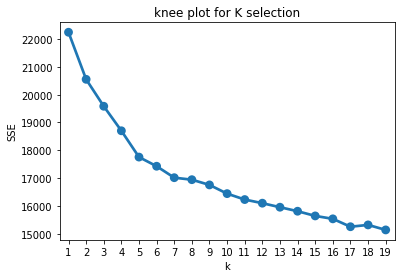

knee = 7


In [ ]:
# Knee gives 4 takes too long to run and too much ram
knee = knee_loc(tf_idf_ftx)

In [ ]:
model_knee_ftx = kmeans_topics(tf_idf_ftx, knee.knee)

100%|██████████| 7/7 [00:00<00:00, 873.84it/s]

(0, 16460),crypto,体彩,bitcoin,btc,足球,sbf,binance,money,amp,blockfi,世界杯买球,bankruptcy,ftxscam,whalechart,世界杯投注,
(1, 1837),carefu,deserve,plot,wait,end,guy,dubtc,lost,offer,ceo,crypto,volume,price,alamedaresearch,mins,
(2, 617),results,trends,bullish,pair,top,perp,dyor,signals,buy,usd,bito,spy,amzn,cake,gbtc,
(3, 841),sets,date,dec,committee,unideftimes,hearing,house,read,us,report,states,fixed,services,hold,financial,
(4, 408),pacs,situat,executives,investigate,trust,davidgiglioca,mccarthy,kevin,took,situation,true,becomes,gopleader,ceo,hearing,
(5, 1134),amazed,arrive,fast,came,ripple,minutes,wallet,took,alamedaresearch,binance,xrpaynet,crypto,volume,price,plot,
(6, 1524),volume,impact,price,sell,buy,skewed,mismatch,mins,past,average,btcusdt,usdtusd,usdtperp,brzperp,atomusd,


In [ ]:
tweets(df_ftx, model_knee_ftx)

Topic 1 
 ['RT @riskigy: Cryptocurrency exchange #FTX will provide around $6 million in compensation to victims of a #phishing scam that allowed hacker…'
 '@xPositiveClimb $THE Takeover  #BinanceTHE @THEProtocolERC  #Etherum  #Gateio  #BitMart  #MEXCGlobal  #Bitget  #Bitgert  #KuCoin  #FTX  #Binance  #Huobi  #Coinbase  #Kraken  #Cryptocurency  #Bitcoin  #100x  #CMC  #Coingecko'
 'Harry Huggins Nathan Sawyer Herman Gosse Rachel Jean #体彩 #FTX #世界杯直播 https://t.co/QduLOox68O']
Topic 2 
 ["RT @DU09BTC: Wait till the end. 👇  #FTX CEO has lost the plot IMO. This guy does not deserve what crypto has to offer.   I'd be very carefu…"
 "RT @DU09BTC: Wait till the end. 👇  #FTX CEO has lost the plot IMO. This guy does not deserve what crypto has to offer.   I'd be very carefu…"
 "RT @DU09BTC: Wait till the end. 👇  #FTX CEO has lost the plot IMO. This guy does not deserve what crypto has to offer.   I'd be very carefu…"]
Topic 3 
 ['[Scan results - #FTX - 1h]  Top 5 bullish trends on $PERP pair 1: $

# Daily prices of Bitcoin and Etherium

# Sentiment over years/months

In [21]:
#display the names of the columns
df_ftx.columns
#df_ftx_sent = df_ftx[['', 'C', 'D']].copy()

Index(['author id', 'username', 'created_at', 'geo', 'id', 'lang',
       'like_count', 'quote_count', 'reply_count', 'retweet_count', 'source',
       'tweet', 'in_reply_to', 'users', 'followers', 'tweet count',
       'clean_text', 'tokens', 'clean_text_lemma', 'adj'],
      dtype='object')

In [22]:
#create new dataframe by selecting the columns you are interested for
df_ftx_sent = df_ftx[['clean_text_lemma', 'created_at']].copy()

In [23]:
df_ftx_sent.head()

,clean_text_lemma,created_at
0,vitainucoin vinu listed ftxapp blockfolio vinu...,2022-10-30 23:58:36+00:00
1,riskigy cryptocurrency exchange ftx provide co...,2022-10-30 23:56:41+00:00
3,elemontcapital tier exchange vinu listing next...,2022-10-30 23:56:05+00:00
4,vitainucoin vinu listing ftxapp details come v...,2022-10-30 23:54:44+00:00
5,finalfx huge blessed week vvl nft btc ftx,2022-10-30 23:54:36+00:00


In [30]:
#Create a function to get the polarity and subjectivity
#Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment.
#Subjectivity lies between [0,1]. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.
#https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524#:~:text=TextBlob%20is%20a%20simple%20library,classifying%20negative%20and%20positive%20words.
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity


#Create a column of sentiment polarity
df_ftx_sent['polarity'] = df_ftx_sent['clean_text_lemma'].apply(getPolarity)
df_ftx_sent['subjectivity'] = df_ftx_sent['clean_text_lemma'].apply(getSubjectivity)



In [31]:
#Get the sentiment of every tweet based on the threshold of polarity we will set
#If the polarity is less than 0 then the tweet is negative etc.
def getSentiment(score):
    if score < 0: 
      return 'negative'
    elif score == 0:
      return 'neutral'
    else:
      return 'positive'

df_ftx_sent['sentiment'] = df_ftx_sent['polarity'].apply(getSentiment)
df_ftx_sent

,clean_text_lemma,created_at,polarity,subjectivity,sentiment
0,vitainucoin vinu listed ftxapp blockfolio vinu...,2022-10-30 23:58:36+00:00,0.0,0.0,neutral
1,riskigy cryptocurrency exchange ftx provide co...,2022-10-30 23:56:41+00:00,0.0,0.0,neutral
3,elemontcapital tier exchange vinu listing next...,2022-10-30 23:56:05+00:00,0.0,0.0,neutral
4,vitainucoin vinu listing ftxapp details come v...,2022-10-30 23:54:44+00:00,0.0,0.0,neutral
5,finalfx huge blessed week vvl nft btc ftx,2022-10-30 23:54:36+00:00,0.4,0.9,positive
...,...,...,...,...,...
29252,took minutes arrive wallet amazed fast came ri...,2022-12-06 15:04:37+00:00,0.2,0.6,positive
29257,april powell steven poe burnell lewis flora ru...,2022-12-06 15:04:22+00:00,0.0,0.0,neutral
29258,amuletprotocol icymi appeared stakingrewards i...,2022-12-06 15:04:21+00:00,0.9,0.9,positive
29260,christalball chainsaw article manipulation amc...,2022-12-06 15:04:16+00:00,0.0,0.0,neutral


In [33]:
Positive = df_ftx_sent[df_ftx_sent['sentiment'] =='positive']
print(str(Positive.shape[0] / (df_ftx_sent.shape[0]) * 100) + '% of positive tweets')
Pos = Positive.shape[0] / df_ftx_sent.shape[0] * 100

26.050567459795804% of positive tweets


In [35]:
Negative = df_ftx_sent[df_ftx_sent['sentiment'] =='negative']
print(str(Negative.shape[0] / (df_ftx_sent.shape[0]) * 100) + '% of negative tweets')
Neg = Negative.shape[0] / df_ftx_sent.shape[0] * 100

15.73550677008019% of negative tweets


In [36]:
Neutral = df_ftx_sent[df_ftx_sent['sentiment'] =='neutral']
print(str(Neutral.shape[0] / (df_ftx_sent.shape[0]) * 100) + '% of neutral tweets')
Neut = Neutral.shape[0] / df_ftx_sent.shape[0] * 100

58.21392577012401% of neutral tweets


In [37]:
df_ftx_sent.to_csv('/content/drive/MyDrive/ADS/Critical Data Mining of Media Culture - Copy/Weeks/ftx_sentiment_thanos.csv',index= False)

# Topic Modelling over the years/months